### **MelodAI — GPT-like MIDI Generative Music Exploration**

This project explores the generative capabilities of GPT-style transformer architectures for music composition, leveraging the rich and diverse datasets provided by Google’s Magenta. By training a model on symbolic music data, we aim to produce coherent and expressive musical sequences.

While MIDI technology has existed for decades—providing professionals and researchers with tools for sequencing and digital composition—the concept of generative music without the need for extensive compositional skills or complex algorithmic tools is relatively new. Traditionally, creating music required either creative expertise or specialized software. However, in the past couple of decades, advances in GPT (Generative Pre-trained Transformer) research have made it possible to generate learned responses through simple prompts.

These same transformer models are now being applied to generative music. By leveraging MIDI—a well-established format for digital music encoding—we can integrate tools like Miditok, which tokenizes MIDI files into sequences of numerical IDs. This allows us to treat music as a structured time-series dataset, ideal for transformer-based modeling. Like with LSTMs (which we were introduced to a few weeks ago), GPT-like models can learn from these sequences to understand and generate music, discovering patterns within musical time and structure.


### What Are the Tokenized ID Attributes in Time-Series Music?

Let’s briefly touch on how music is represented as a sequence. If you have any background in music theory, you’ll recall that Western staff notation is read left to right, similar to most written languages. At the beginning of a staff, we typically see a time signature, which tells us how many beats are in each bar and how those beats are divided.

Each note on the staff contains several important attributes:
- Pitch: The vertical position of the note indicates its frequency.
- Time Shift: How much time passes *before* the note is played (relative to the previous note).
- Duration: How long the note is held.
- Velocity: The intensity or "loudness" of the note—how hard a piano key is struck, a string is plucked, or a note is blown.

An important distinction is that duration and time shift are not the same. A note might end before the next one begins, introducing a pause or rest. Together, these four attributes—Pitch, Velocity, Duration, and Time Shift—define a single note event in our model.


### So How Does Tokenization Work?

You can think of a MIDI file as a piece of text, with musical grammar rules. Just like text has words, sentences, and paragraphs, music has notes, bars, and sections. In tokenization, each note event (or its components) becomes a token. These tokens form a vocabulary that our model learns from.

There are two common tokenization strategies:
- Treating an entire note event (with all attributes) as a single token.
- Separating each attribute (e.g., Pitch, Duration) into its own token, preserving order in a structured sequence.

We will use the latter first, for a more granular approach—structured tokenization—which tends to perform well with transformer models and requires less training to achieve good generalization.  We will also try tokenizing by note event, combining all four attibutes into a single word token.

### GPT vs. LSTM in Music Generation

Much like LSTM models, GPT-style transformers process sequences using a moving window approach. However, unlike LSTMs, GPT models are decoder-only: they don’t encode and decode. Instead, they predict the next token based on the sequence of tokens that came before it.

### What Does a GPT Output Look Like?

When a GPT-like model is trained and given a token, it generates a logit, a 1D tensor representing the model’s learned grammar. This output is passed through a softmax function to create a probability distribution over the entire vocabulary. Using this weighted distribution, we can randomly sample the next token—where "random" is influenced by how likely each token is, based on learned patterns.

This process allows for creativity and variation in generation, while still following the learned structure of music.


Later on, we’ll introduce the specifics of the GPT-like architecture. But for now—let’s dive in! 

Let's use the GPU unit if it is available to speed up the deep learning model

In [144]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


The Maestro-v3.0.0.csv file conveniently provides us data split information for training, testing and validation.  We can also see the names of music composers.  It is worth noting that this music dataset is largely aimed at learning Classical Music and is predominantly biased with western music composition, so this deep learning project appreciate a particularly limited sphere of music, and even regarding the set of learned music, it is even more limited in that, the the producers of the dataset largely left recorded compositions to the piano as we shall see later.  I'll provide some context on why this is especially the case.

### Exploratory Data Analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the MAESTRO metadata CSV
csv_path = "data/maestro/maestro-v3.0.0/maestro-v3.0.0.csv"
df = pd.read_csv(csv_path)

# Preview the data
df.head()


,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508


In [3]:
print(f"Total MIDI files: {len(df)}")


Total MIDI files: 1276


In [49]:
midi_path = "/home/christophermoverton/MelodAI_proj/data/maestro/maestro-v3.0.0/2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.midi"


Here is a demonstration of a note event using the `pretty_midi` module.  
Note: Although `pretty_midi` provides a helpful way to visualize and understand the structure of a note event, we will *not* be using it for tokenization in this project.

You’ll notice that instead of a separate duration attribute, each note is defined by a `start` and `end` time. This differs from other time representations—particularly the time shift and duration format used in tokenization for transformer models. In the `pretty_midi` representation, notes are placed on a global (absolute) timeline, meaning their timing is fixed relative to the beginning of the piece, rather than described by their position relative to surrounding notes.

While this global positioning is useful for exact playback or temporal analysis, it loses the immediate local context that time-series models benefit from—such as how one note temporally relates to the next. In contrast, models trained on time shift and duration can learn musical phrasing, rhythm, and expressive timing more naturally by understanding these relative relationships.


In [54]:
import pretty_midi

midi = pretty_midi.PrettyMIDI(midi_path)

for i, instr in enumerate(midi.instruments):
    print(f"\n🎹 Instrument {i}: Program={instr.program}, Is Drum={instr.is_drum}, Name={instr.name}")
    
    for note in instr.notes[:10]:  # just show first 10 notes
        print(f"Note: pitch={note.pitch}, start={note.start:.2f}, end={note.end:.2f}, velocity={note.velocity}")
    print(len(instr.notes))



🎹 Instrument 0: Program=0, Is Drum=False, Name=
Note: pitch=71, start=1.09, end=1.19, velocity=60
Note: pitch=55, start=1.28, end=1.50, velocity=44
Note: pitch=59, start=1.46, end=1.63, velocity=55
Note: pitch=62, start=1.63, end=1.75, velocity=52
Note: pitch=71, start=1.29, end=1.79, velocity=54
Note: pitch=72, start=1.79, end=1.83, velocity=76
Note: pitch=67, start=1.80, end=2.00, velocity=56
Note: pitch=74, start=1.98, end=2.10, velocity=68
Note: pitch=72, start=2.04, end=2.11, velocity=77
Note: pitch=74, start=2.10, end=2.18, velocity=51
7894


Chopin has a large number of compositions in this dataset—but why might that be useful to know?  
Chopin primarily composed music for the parlor, a popular domestic setting in the 19th century, and the most common instrument in parlors was the piano. His works, rich in expressive phrasing and romanticism, were tailored for intimate performances, which is reflected in the quantity and style of his piano-focused compositions.

Similarly, Franz Schubert—another prolific composer in this dataset—also wrote extensively for the piano, often for salons and small gatherings. His music bridged classical forms with romantic emotion, making it widely accessible and enduring.

Ludwig van Beethoven, despite losing his hearing later in life, continued to compose masterworks that pushed the boundaries of form and expression. While he is known for symphonies and larger works, many of his compositions also centered around the piano.

Johann Sebastian Bach, on the other hand, lived much earlier and often traveled on foot across Germany to perform and compose, especially for churches. His output includes a significant number of keyboard works (organ and harpsichord), further contributing to his high count in this dataset.

Each of these composers contributed not just through sheer quantity, but through works tailored to the performance contexts and instruments of their era. These historical insights help contextualize the distribution shown in the bar chart—and hint at how musical traditions and settings influence data in our generative modeling efforts.


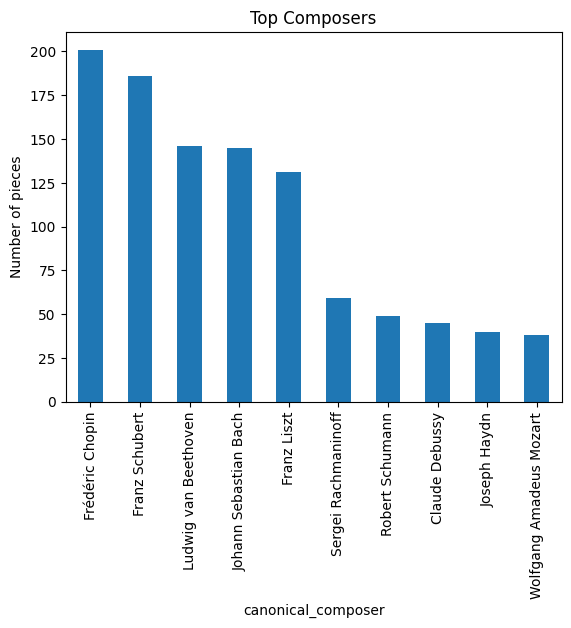

In [4]:
df['canonical_composer'].value_counts().head(10).plot(kind='bar', title='Top Composers')
plt.ylabel("Number of pieces")
plt.show()




  Distribution Characteristics:
- Most pieces have durations clustered on the left side of the graph — under 600 seconds (10 minutes).
- There's a long tail extending to the right, with fewer pieces stretching out to 2500+ seconds (over 40 minutes).
- The mode (the peak) occurs somewhere between 200 and 400 seconds, which suggests that shorter pieces are most common in your dataset.

Musical Insight:
This makes sense for classical music datasets — especially with composers like Chopin or Schubert who wrote many shorter, solo piano works. Longer durations may reflect symphonies, concertos, or large-scale choral/orchestral works, which are less frequent in most symbolic music datasets.

For added consideration, I like to reflect on the audience setting that the composer may have envisioned when creating these pieces. Were the listeners already seated for a formal, concert-style performance? Or was the setting more casual and social in nature? Was the music intended to command focused attention, or was it designed as elegant background entertainment for gatherings?

As mentioned earlier, Chopin and Schubert were known for their waltzes, nocturnes, and impromptus—pieces often composed for parlor settings, where guests were likely coming and going. These works were typically brief, often lasting only a few minutes, and could easily accompany dancing or casual conversation.

In contrast, longer, symphonic-style compositions were designed for more structured and immersive performances. Yet, the composers most prolific in this dataset often leaned toward shorter works, and that’s reflected in the distribution of piece durations we see.

It’s helpful to think of these compositions as the commercial entertainment of their time. Guests at a salon or soirée might engage in conversation while a nocturne played softly in the background. And while Chopin’s music certainly includes deeply intimate moments, his waltzes were also crafted to entertain—they weren’t just "another dance piece" but aimed to captivate and charm their listeners.

Beyond this consideration, how might the GPT model interpret and prompt respond based upon the bulk of compositions that say peak at less than 500 seconds in duration?  Perhaps, we might have predictions more inclined to supply improptus and waltzes from our training set, or shorter compositional pieces?  

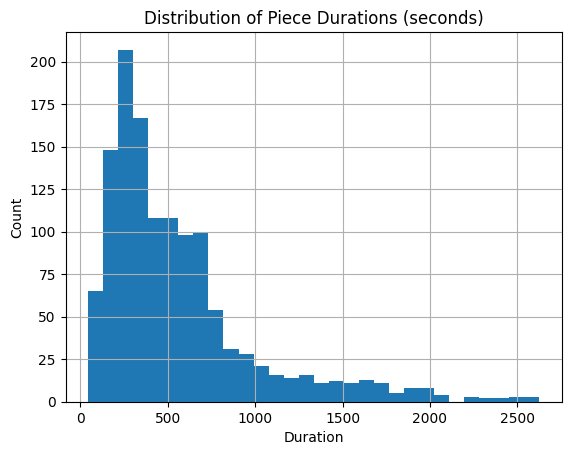

In [5]:
df['duration'].hist(bins=30)
plt.title("Distribution of Piece Durations (seconds)")
plt.xlabel("Duration")
plt.ylabel("Count")
plt.show()


Our peak midi note is approximately 65.  This correponds to F4, or 5 semitones from middle C.  This is solidly in the Soprano range, and it is a common range for choral arrangements, and it is common in melodic arrangments.  

100%|███████████████████████████████████████████████████| 1276/1276 [02:10<00:00,  9.74it/s]


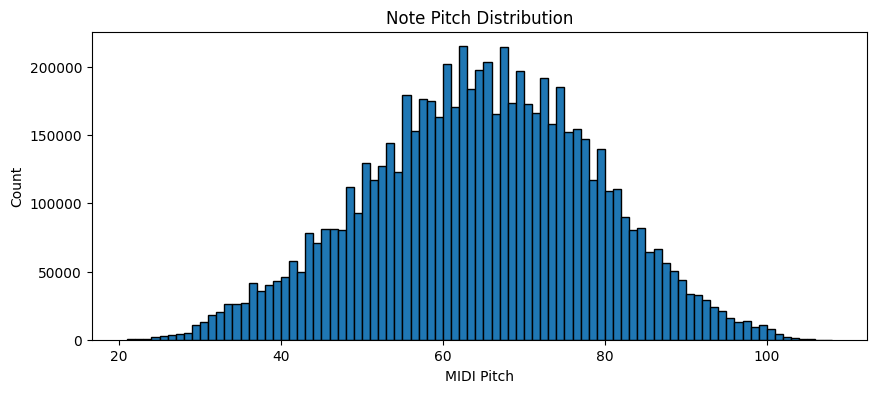

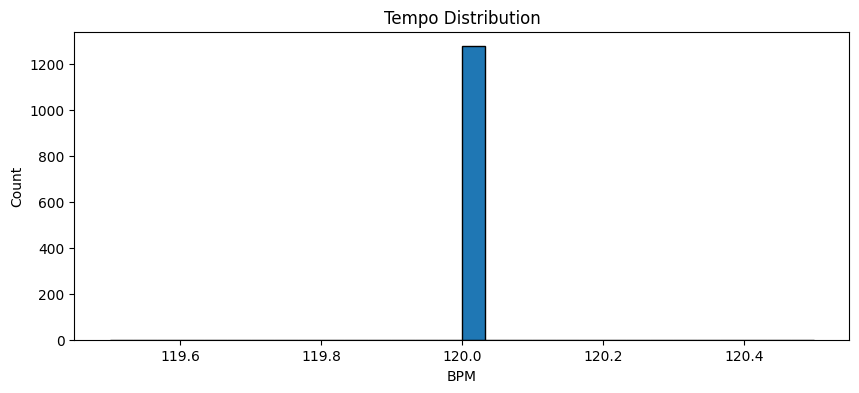

In [7]:
import pandas as pd
import pretty_midi
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# Load metadata
csv_path = "data/maestro/maestro-v3.0.0/maestro-v3.0.0.csv"
root_path = "data/maestro/maestro-v3.0.0"
df = pd.read_csv(csv_path)

# Paths
midi_root = root_path#os.path.join(os.path.dirname(csv_path), "midi")

# Initialize storage
all_pitches = []
all_tempos = []

# Loop through a small subset first (you can expand later)
for _, row in tqdm(df.iterrows(), total=len(df)):
    midi_path = os.path.join(midi_root, row["midi_filename"])
    try:
        midi = pretty_midi.PrettyMIDI(midi_path)

        # Gather pitches
        for instrument in midi.instruments:
            if not instrument.is_drum:
                for note in instrument.notes:
                    all_pitches.append(note.pitch)

        # Gather tempo estimates
        tempos = midi.get_tempo_changes()[1]
        all_tempos.extend(tempos)

    except Exception as e:
        print(f"Error loading {midi_path}: {e}")

# Plot histogram of note pitches (MIDI pitch numbers)
plt.figure(figsize=(10, 4))
plt.hist(all_pitches, bins=range(21, 109), edgecolor='black')  # MIDI piano range
plt.title("Note Pitch Distribution")
plt.xlabel("MIDI Pitch")
plt.ylabel("Count")
plt.show()

# Plot histogram of tempos (BPM)
plt.figure(figsize=(10, 4))
plt.hist(all_tempos, bins=30, edgecolor='black')
plt.title("Tempo Distribution")
plt.xlabel("BPM")
plt.ylabel("Count")
plt.show()


In [10]:
import pandas as pd
import pretty_midi
import os
from tqdm import tqdm

# Load metadata CSV
csv_path = "data/maestro/maestro-v3.0.0/maestro-v3.0.0.csv"
df = pd.read_csv(csv_path)

# Base path to MIDI files
midi_root = root_path#os.path.join(os.path.dirname(csv_path), "midi")

# Initialize list of PrettyMIDI objects
all_midi_files = []

# Optionally: filter by split (e.g., 'train')
df_filtered = df[df['split'] == 'train']

# Load all MIDI files (can limit to a small subset first)
for _, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    midi_path = os.path.join(midi_root, row['midi_filename'])
    try:
        midi = pretty_midi.PrettyMIDI(midi_path)
        all_midi_files.append(midi)
    except Exception as e:
        print(f"Error loading {midi_path}: {e}")


100%|█████████████████████████████████████████████████████| 962/962 [01:44<00:00,  9.17it/s]


We observe a peak note density of around 9 notes per second. This level of density is more commonly found in works such as Chopin’s études, Liszt’s rhapsodies, and Paganini’s caprices. Higher note densities often reflect rapid trills, virtuosic runs, or stylistic ornamentation.

Since we’re averaging note events across the full duration of a piece, it’s worth noting that this suggests not just occasional flourishes, but consistently intricate composition. While such passages are challenging for many instruments, they are more naturally handled on the piano, which these composers primarily wrote for.

These pieces are not only rhythmically intense, but also compositionally dense. If we think back to Chopin’s waltzes, they’re not merely slow, elegant dances—they’re often packed with ornamentation, expressive gestures, and a high degree of stylistic energy.

As to compositions that were likely danceable in the ballroom, it is worth noting Chopin was likely a bit too energetic.  Strauss or Lanner, yes, they did produce waltzes that one could dance!  

Text(0.5, 1.0, 'Note Density (Notes per Second)')

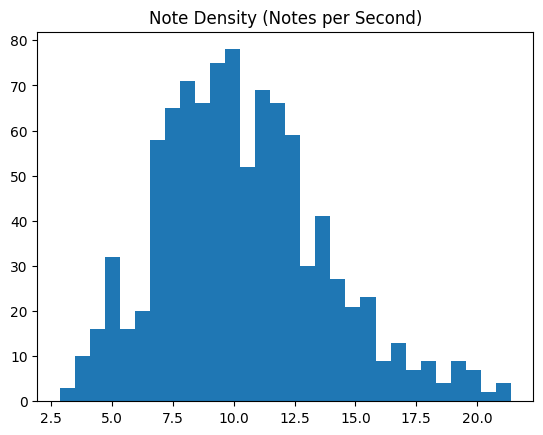

In [11]:
notes_per_second = [len(pm.instruments[0].notes) / pm.get_end_time() for pm in all_midi_files]
plt.hist(notes_per_second, bins=30)
plt.title("Note Density (Notes per Second)")


Text(0.5, 1.0, 'Estimated Token Count per File')

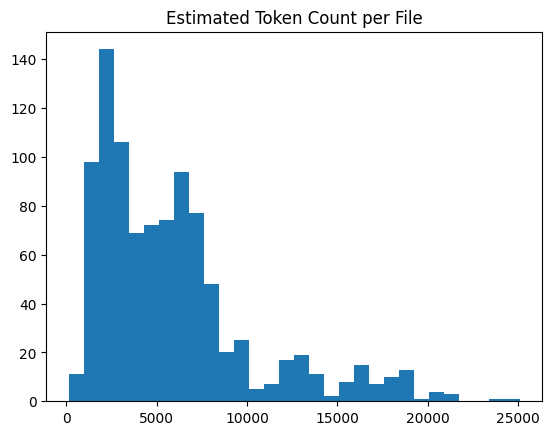

In [12]:
avg_notes = [sum(len(inst.notes) for inst in pm.instruments) for pm in all_midi_files]
plt.hist(avg_notes, bins=30)
plt.title("Estimated Token Count per File")


We can see below the minimum and maximum pitch range.  If composition for the piano appreciates a wide variability in range, composers could also have the added task of thinking about the range of their singer's voice or the range that a choral group might have.  If they play notes that deviate below the range of the soprano, then the soprano may find the composition impossible to sing, so bracketing compositional range could be important when composing say for a mezzo-soprano versus soprano, or alto.  Also if the composer is thinking of the piano as instrument, they know from a music theory standpoint the ranges of various instruments in symphony, so some instrument groups might be bracketed within ranges that certain instrument sections in the symphony can play.  The widest min max ranges suggest piano ranges, while the narrowest ranges might suggest accompaniment via instrument likes woodwinds (namely, flutes), or violins, etc.  We definitely see a lot of for piano compositions from the graph shown below.

Text(0.5, 1.0, 'Pitch Ranges per Piece')

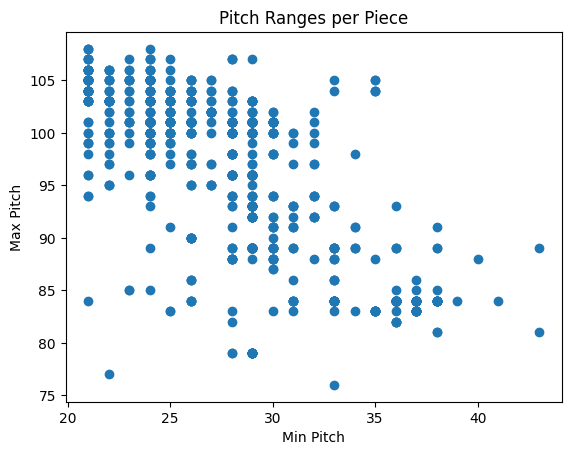

In [13]:
pitch_ranges = [(min(note.pitch for inst in pm.instruments for note in inst.notes),
                 max(note.pitch for inst in pm.instruments for note in inst.notes))
                for pm in all_midi_files]

min_pitches, max_pitches = zip(*pitch_ranges)
plt.scatter(min_pitches, max_pitches)
plt.xlabel("Min Pitch")
plt.ylabel("Max Pitch")
plt.title("Pitch Ranges per Piece")


Chopin tops the music charts in terms of volume of compositions, and if he were by in large thinking about the shorter dance pieces, this might explain the numbers.  Chopin definitely loved the piano and its intimacy, but he never composed one symphony.  Beethoven, on the other hand, composed nine landmark symphonies.  Schubert also composed nine symphonies.  There is also, owing to Beethoven(?), the "curse of the ninth" symphony.  Generally, this was a superstition that no composer would ever live to compose more than 9 symphonies! 

Text(0.5, 1.0, 'Composer Distribution')

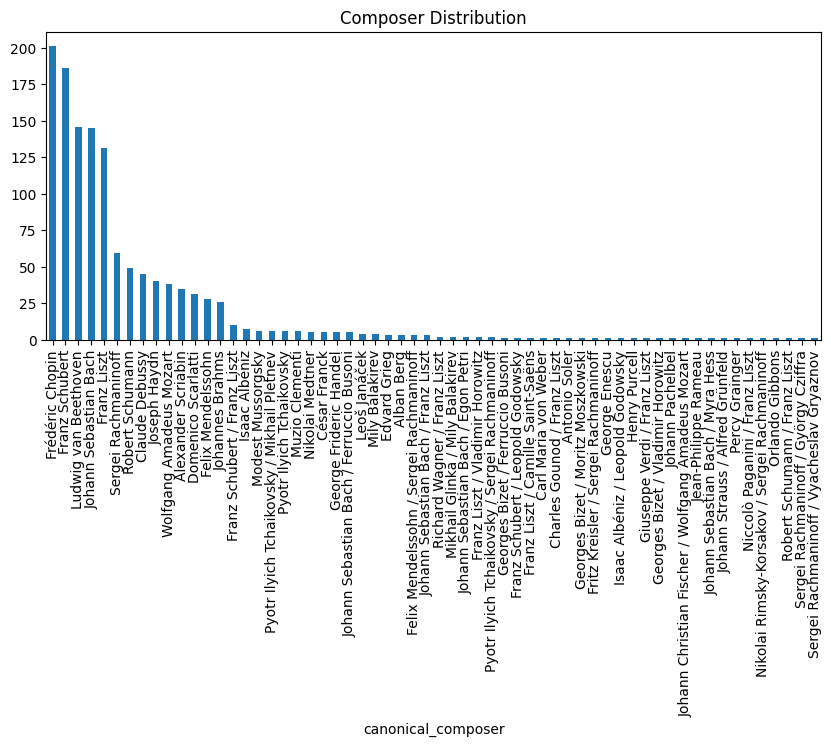

In [14]:
df['canonical_composer'].value_counts().plot(kind='bar', figsize=(10,4))
plt.title("Composer Distribution")


Text(0.5, 1.0, 'MIDI Duration Distribution')

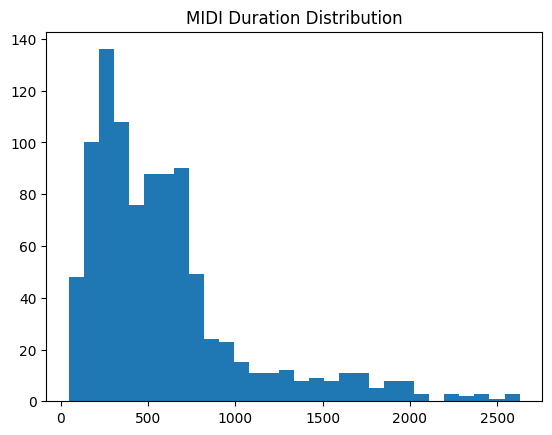

In [15]:
durations = [pm.get_end_time() for pm in all_midi_files]
plt.hist(durations, bins=30)
plt.title("MIDI Duration Distribution")


Let's go ahead and configure our Tokenizer.  In this case, while we won't use REMI, we will use this as an example of exploring tokenization further, and then rendering midi, alongside representing a music piece on the familiar piano roll. 

In [17]:
from miditok import REMI
from miditok import TokSequence
from pathlib import Path

# Paths
midi_dir = Path("data/maestro/maestro-v3.0.0")
token_dir = Path("data/tokens/remi")
token_dir.mkdir(parents=True, exist_ok=True)

# Create a REMI tokenizer
tokenizer = REMI(tokenizer_config=None)  # default config


In [19]:
from tqdm import tqdm
import pretty_midi

midi_paths = list(midi_dir.glob("**/*.midi"))  # or .mid

for midi_path in tqdm(midi_paths):
    try:
        tokens = tokenizer(midi_path)  # returns a list of TokSequence
        # Save token file with same name but .json extension
        token_save_path = token_dir / midi_path.with_suffix(".json").name
        # Save tokens (REMI will handle JSON formatting + path)
        tokenizer.save_tokens(tokens, token_dir / midi_path.with_suffix(".json").name)
    except Exception as e:
        print(f"Error tokenizing {midi_path.name}: {e}")


100%|███████████████████████████████████████████████████| 1276/1276 [00:53<00:00, 23.92it/s]


In [1]:
from miditok import REMI
from pathlib import Path

# Path to your tokenized file /home/christophermoverton/MelodAI_proj/data/tokens/remi/MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_01_Track01_wav.json
token_path = Path("data/tokens/remi/MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_01_Track01_wav.json")

# Create the same tokenizer you used to save the file
tokenizer = REMI()

# Load the token sequence
token_sequence = tokenizer.load_tokens(token_path)

# Print first few tokens
print(token_sequence[0].ids[:20])



[4, 206, 26, 110, 135, 215, 33, 112, 131, 4, 189, 41, 113, 126, 194, 41, 114, 127, 197, 33]


/home/christophermoverton/MelodAI_proj/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Below shows the tokenized output of a given track.  Note: we have to decode the token ids to understand what token events are actually taking place.  Otherwise, these token ids are just numbers replacing their vocabulary mapped labels.  Unlike Structured tokenization, REMI has timing represented in terms of Bar and position (with that bar). Also rests (or pauses) in Remi can be tokenized which can lead to irregular periodic structure.  As it turns out, using REMI without added constraints using default vocabularies, or training, can introduce problems for the basic GPT of overfitting (especially in building custom training vocabularies).  Tempo is also mapped in a periodic, if not redundant manner although it is not shown below.  Neither are 'Rests' shown below.

In [2]:
# Load the token sequence
token_sequence = tokenizer.load_tokens(token_path)[0]

# Reverse the vocab dict to map IDs back to strings
id_to_token = {v: k for k, v in tokenizer.vocab.items()}

# Use it to convert your token IDs
token_strings = [id_to_token[i] for i in token_sequence.ids]

print(token_strings[:50])



['Bar_None', 'Position_17', 'Pitch_42', 'Velocity_71', 'Duration_1.3.8', 'Position_26', 'Pitch_49', 'Velocity_79', 'Duration_0.7.8', 'Bar_None', 'Position_0', 'Pitch_57', 'Velocity_83', 'Duration_0.2.8', 'Position_5', 'Pitch_57', 'Velocity_87', 'Duration_0.3.8', 'Position_8', 'Pitch_49', 'Velocity_83', 'Duration_0.4.8', 'Position_11', 'Pitch_42', 'Velocity_83', 'Duration_0.2.8', 'Position_15', 'Pitch_42', 'Velocity_75', 'Duration_0.6.8', 'Position_19', 'Pitch_49', 'Velocity_79', 'Duration_0.5.8', 'Position_24', 'Pitch_57', 'Velocity_75', 'Duration_0.1.8', 'Position_26', 'Pitch_61', 'Velocity_95', 'Duration_0.4.8', 'Position_28', 'Pitch_66', 'Velocity_87', 'Duration_4.2.4', 'Pitch_42', 'Velocity_63', 'Duration_1.3.8', 'Bar_None']


In [3]:
# Decode the token sequence back into a PrettyMIDI object
midi = tokenizer.decode([token_sequence])


In [4]:
decoded = tokenizer.decode([token_sequence])
print(type(decoded))


<class 'symusic.core.ScoreTick'>


Doing a quick verification of fluidsynth.  Using the customary pip install of the pyfluidsynth package, hadn't worked as 

hoped, so downloaded the git repo from the author of the module direct and did a 'pip install .' installation which 

correctly provided the package to my virtual environment.  

In [8]:
import fluidsynth
print(fluidsynth.__file__)


/home/christophermoverton/MelodAI_proj/venv/lib/python3.12/site-packages/fluidsynth.py




##### Instructions and Notes on MIDI Interpretation

To proceed, first run the third cell below (below the humanize_midi function cell) and listen to the MIDI audio file. Then, run the next two cells that proceeds the third cell, and finally, run the third cell again to listen for differences in the performance.

##### Understanding the Role of MIDI and Humanization in Musical Interpretation

Listening to raw MIDI—even when recorded—often involves quantization, which aligns note timings to exact intervals. This is useful for tasks like transcription into staff notation or producing readable sheet music for concert performance.

However, what makes music compelling isn’t just the notes themselves, but how a musician interprets them. This is especially true in classical music, where listeners are drawn not only to the composer but also to the performer’s unique expression of a piece.

When you run the third cell before applying any humanization (i.e., before running the other two cells), you'll notice the music sounds somewhat rigid or robotic. This mechanical quality arises from quantization, which eliminates the subtle imperfections found in real performances. While quantization helps create cleaner recordings, it also strips away the "human" feel of the performance.

To reintroduce that human element, we can take a couple of basic steps, as shown in the cells below:  
1. Add the sustain pedal to certain notes (a familiar tool for pianists), and  
2. Humanize the MIDI notes by introducing slight randomness.

Interestingly, our ears tend to pick up pitch errors more readily than slight timing variations. Before the rise of computer-generated music and synthetic sounds, acoustic instruments like the piano were expected to have natural inconsistencies—slight fluctuations in timing and key velocity (i.e., how hard or softly a note is played).

To simulate this natural performance, we add small stochastic variations in timing and velocity. These imperfections make the music sound more organic to human ears. In digital music composition, this phenomenon is often referred to as a neurological-acoustic illusion, somewhat akin to pareidolia. Just as our minds find familiar patterns in random visuals, we perceive nearly impercitible and randomized note timings as sounding more "correct" or human—while overly precise, quantized notes may feel awkward or artificial especially if the synthesized note is clipped or truncated relative the expected sound from a natural instrument.  This isn't also to say that we don't have a good sense of arrythmic structure, it just isn't perhaps, as perfect as we like to believe.

Even in modern computer-generated music, depending on the style, humanization is often applied to create more natural-sounding drum patterns, instrumental phrasing, or rhythmic grooves.




In [180]:
import pretty_midi

def add_sustain_pedal(midi_obj, start_time=0, end_time=None):
    """
    Adds sustain pedal (CC 64) to the entire MIDI duration or a custom time range.
    """
    if end_time is None:
        end_time = midi_obj.get_end_time()

    # Sustain ON (CC 64 value 127), then OFF (value 0)
    control_changes = [
        pretty_midi.ControlChange(number=64, value=127, time=start_time),
        pretty_midi.ControlChange(number=64, value=0, time=end_time)
    ]

    # Apply to all non-drum instruments
    for instrument in midi_obj.instruments:
        if not instrument.is_drum:
            instrument.control_changes.extend(control_changes)

add_sustain_pedal(midi)

In [179]:
import random

def humanize_midi(midi_obj, timing_variation=0.02, velocity_variation=5):
    """
    Slightly randomize note timing and velocity to sound more human.
    """
    for instrument in midi_obj.instruments:
        for note in instrument.notes:
            # Shift timing slightly
            delta = random.uniform(-timing_variation, timing_variation)
            note.start += delta
            note.end += delta
            
            # Clamp to zero if needed
            note.start = max(0, note.start)
            note.end = max(note.start + 0.01, note.end)  # min length
            
            # Vary velocity
            note.velocity = max(1, min(127, note.velocity + random.randint(-velocity_variation, velocity_variation)))

humanize_midi(midi)

In [ ]:
from IPython.display import Audio
import fluidsynth

audio = Audio(midi.fluidsynth(), rate=44100)
audio


Here is the familiar piano roll shown below.  Note pitch increasing on the descending y axis, while it is lower on the upper y axis.  If you have any familarity working with Digital Audio Workstation software, you will see the Piano Roll commonly as a compositional tool.  Typically, amongst zooming features on both axis, you can also see quantized grid overlays that show where the note exist relative the quantized grid.  Most basic DAW software allows one to select quantize sections of a given music piece (or all) so that it conforms to the nearest neighbor quantization point.  The Piano roll name also derives from the concept of the literal piano roll which was ostensibly long paper rolled between two pins.  In 1880 some pianos had foot pumped pneumatic systems that allowed a piano with piano roll capabilities to automate the playing of a piano roll loaded song into the piano.  The piano roll worked not unlike a music box that had a spiked cylinder which represented timing and pitch of a note, however, even more that would include duration of notes (and foot pedaling expressions).  In the case of the piano roll notation on the heavy paper, there were dots or longer dashes cutout in the paper along a y-axsis representing note pitch, and the longer dash for example represented length-wise on the axis of the paper represented note duration.  

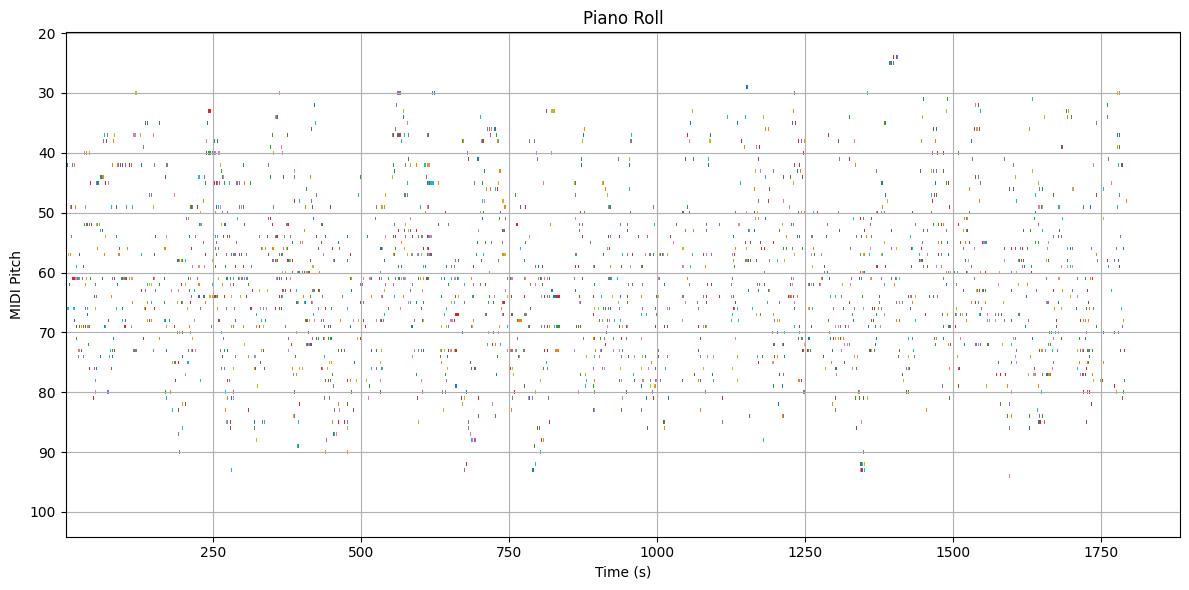

In [7]:
import matplotlib.pyplot as plt
import pretty_midi
import numpy as np

def plot_piano_roll(midi_obj, instrument_idx=0):
    instrument = midi_obj.instruments[instrument_idx]
    notes = instrument.notes

    starts = [note.start for note in notes]
    durations = [note.end - note.start for note in notes]
    pitches = [note.pitch for note in notes]

    plt.figure(figsize=(12, 6))
    for start, duration, pitch in zip(starts, durations, pitches):
        plt.barh(y=pitch, width=duration, left=start, height=0.6)

    plt.xlabel("Time (s)")
    plt.ylabel("MIDI Pitch")
    plt.title("Piano Roll")
    plt.gca().invert_yaxis()  # Highest pitch at top
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the plot
plot_piano_roll(midi)


### Tokenization for Modeling

As indicated before, let's go ahead and setup our stuctured tokenization.  Since we are using a GPT-like transformer, I'd like to keep the training simpler in terms of prepared data.  I won't actually fit the tokenizer with training data since this builds a custom vocabulary for the tokenizer, but in doing so given the bulk of the dataset, it is difficult to capture all possible vocabularies since a note event representing a token (like word) could have $(j*k*l*m)$ discrete permutations where $j$ is all the possible discrete note pitch variations $j= 127$, $k =$ duration$=15$ for basic duration variances,  $l =$ velocity $= 127$ (distinct) variations, and $m =$ timeshift $= 15$ (again basic variations) $= 3,629,025$ possible tokens (words). If we were to build a larger discrete set for duration and timeshift then this number grows larger.  We could restrict to the minimum and maximum pitch boundaries, as well as velocity signatures for the entirety of the dataset, but I'll leave this as open opportunity for future research, and opt that we don't train the custom vocabulary.  This, in effect, leaves the default pitch -> velocity -> duration -> timeshift tokenization pattern. That is, we will for our first model setup tokenize with attributes mapped to word tokens distinctly.  

In [206]:
import pandas as pd

df = pd.read_csv("data/maestro/maestro-v3.0.0/maestro-v3.0.0.csv")

train_files = df[df["split"] == "train"]["midi_filename"].tolist()
val_files = df[df["split"] == "validation"]["midi_filename"].tolist()
test_files = df[df["split"] == "test"]["midi_filename"].tolist()


In [29]:
from miditok import Structured
from pathlib import Path
tokenizer = Structured()
#mpaths = []
#for midi_file in train_files:
#    midi_path = Path("data/maestro/maestro-v3.0.0") / midi_file
#    mpaths.append(midi_path)
#print(mpaths)
#tokenizer.train(
#    vocab_size=20000, files_paths=mpaths
#)


If we had a custom tokenization configuration that we wanted to save, we could do so below.

In [5]:
tokenizer.save_params("tokenizer_configs/remi_clean.json")


/tmp/ipykernel_326418/1847007467.py:1: UserWarning: miditok: The `save_params` method had been renamed `save`. It is now depreciated and will be removed in future updates.
  tokenizer.save_params("tokenizer_configs/remi_clean.json")


Similarly loading the configuration for our tokenizer

In [3]:
from miditok import Structured

# Load the tokenizer from saved config
tokenizer = Structured(params="tokenizer_configs/remi_clean.json")

/home/christophermoverton/MelodAI_proj/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's go ahead and create the file tokenizations for train, test, and split datasets.

In [32]:
from pathlib import Path
def save_tokenized_split(tv_files, split_name):
    for midi_file in tv_files:
        midi_path = Path("data/maestro/maestro-v3.0.0") / midi_file
        try:
            tokens = tokenizer(midi_path)
            out_path = Path(f"data/tokens/remi/{split_name}") / midi_file.replace(".midi", ".json")
            out_path.parent.mkdir(parents=True, exist_ok=True)
            tokenizer.save_tokens(tokens, out_path)
        except Exception as e:
            print(f"Error tokenizing {midi_file}: {e}")

save_tokenized_split(train_files, "train")
save_tokenized_split(val_files, "validation")
save_tokenized_split(test_files, "test")


In [28]:
tp = "data/tokens/remi/train/2004/MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_02_Track02_wav.json"

load_token_ids(tp)

dict_keys(['ids', 'ids_encoded'])


Here is a little helper function that helps us basically load the tokenized and encoded song data.  Note: using the "0" represents our piano instrument.  These aren't multi-instrument compositions, otherwise, we would have tokenizers spread accross a much larger multi-dimensional array.

In [33]:
import json

def load_token_ids(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
        #print(data.keys())
        #print(data["ids"][0])
    return data["ids"][0]


To be mindful of our song data, we can think of this data sort of like the video, only there is only a time-series sound component.  Whereas video with images over time-series can represent a lot of data (not withstanding the audio component), it is no less true that there is a lot of time-series data, and we aren't loading merely just the song data, but we are using a sliding window approach to this which is the common methodology for training the GPT-like transformer.  The sliding window means can be visualized like a window of fixed length that has zoomed into a specific length of tokenized music data on the piano roll.  Just as we move the window (that is much smaller width-wise then the piano roll), we are sliding it from left-to-right, so that our GPT-like transformer is learning from the data output from this window.  Its a lot of repeating token data, so with smaller RAM or GPU on board memory, means that streaming the dataset is perferrable.

In [127]:
import tensorflow as tf
from pathlib import Path

def sequence_generator(token_dir, max_seq_len=512, pad_token_id=0):
    token_dir = Path(token_dir)
    files = list(token_dir.glob("**/*.json"))

    for file in files:
        try:
            ids = load_token_ids(file)
            for i in range(0, len(ids) - max_seq_len, 1):

                seq = ids[i:i + max_seq_len + 1]
                # Skip if too short to train on
                if len(seq) < 2:
                    continue

                # Pad input/target to fixed length
                input_seq = seq[:-1]
                target_seq = seq[1:]

                input_seq += [pad_token_id] * (max_seq_len - len(input_seq))
                target_seq += [pad_token_id] * (max_seq_len - len(target_seq))
                yield input_seq, target_seq
        except Exception as e:
            print(f"Error processing {file.name}: {e}")

def build_streaming_dataset(token_dir, max_seq_len=512, batch_size=8, buffer_size=1000):
    output_signature = (
        tf.TensorSpec(shape=(max_seq_len,), dtype=tf.int32),
        tf.TensorSpec(shape=(max_seq_len,), dtype=tf.int32)
    )
    pad_token_id = tokenizer['PAD_None']

    dataset = tf.data.Dataset.from_generator(
        lambda: sequence_generator(token_dir, max_seq_len, pad_token_id),
        output_signature=output_signature,
    )

    return dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [128]:
train_ds = build_streaming_dataset("data/tokens/remi/train", max_seq_len=512, batch_size=8)
val_ds   = build_streaming_dataset("data/tokens/remi/validation", max_seq_len=512, batch_size=8)
test_ds  = build_streaming_dataset("data/tokens/remi/test", max_seq_len=512, batch_size=8)



In [129]:
for batch in val_ds.take(1):
    print("Sample val batch:", batch[0].shape)


Sample val batch: (8, 512)


Just how many windows (sequence) samples exist for the entirety of this data set.  Around 900,000 samples!  Depending on how fast your GPU is training, if it is around 55 ms/second, this is around 14 hours for 1 epoch of training!  :).  Fortunately, if your training is around 6 ms/second, it is about 9 times less time, or maybe around and 1.5 hours per epoch which is reasonable.  I've opted to limit the batch for both train and validation sets.

In [130]:
train_ds = train_ds.take(10000)  # take 10,000 windows
val_ds = val_ds.take(1000)       # take 1,000 windows


### Model

##### The Transformer Model Includes:

- Multi-Head Attention: Allows the model to focus on multiple relevant parts of the sequence simultaneously, capturing relationships between distant tokens—such as harmony, rhythm, or recurring motifs.

- Sequential Feed-Forward Network (FFN): Projects the input into a higher-dimensional space, applies a ReLU activation for non-linear learning, and then projects it back down to the original embedding size. This enables the model to learn complex, hierarchical patterns.

- Residual Connection (Skip Connection): Adds the original input back into the output of a layer. This stabilizes learning, preserves earlier information, and speeds up convergence by preventing vanishing gradients.

- Layer Normalization: Normalizes activations to stabilize and accelerate training.

- Dropout: Randomly drops units during training to prevent overfitting and improve generalization.

##### What Happens in a Transformer Block?

The `call` method in the model performs the following:
1. Applies self-attention → dropout → residual connection + normalization  
2. Applies FFN → dropout → another residual connection + normalization  
3. Returns a sequence of contextualized token embeddings that capture the learned relationships in the input sequence.

##### Why Use This Transformer Architecture for Music?

Transformers are exceptionally effective at sequence modeling. Unlike RNNs or LSTMs, which process sequences step by step, Transformers can attend to the entire sequence at once. This makes it easier to identify long-range dependencies, such as:
- Chord structures
- Melodic phrases
- Rhythmic motifs

They also scale efficiently. Transformers are highly parallelizable, making them faster to train and more suitable for large datasets or longer sequences—like full musical compositions.

##### Token Position and Embedding
In this Transformer-based model for MIDI music generation, each musical event—such as a pitch, time shift, duration, or velocity—is represented as a discrete token. These tokens are first passed through an embedding layer, which transforms each one into a dense vector of fixed size. This allows the model to capture meaningful relationships between different types of musical events beyond simple integer IDs. However, because Transformers process sequences in parallel, they don’t inherently understand the order of the tokens. To solve this, the model also uses positional embeddings, which assign each token a learned vector based on its position in the sequence. By adding the token embedding and the position embedding together, the model gains both semantic understanding of the token and contextual awareness of its place in the musical timeline—crucial for modeling patterns like rhythm, phrasing, and harmonic progression.


In [131]:
import tensorflow as tf
from tensorflow.keras import layers, Model


In [132]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.3):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training, mask=None):
        attn_output = self.att(inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [133]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [134]:
def build_transformer_model(vocab_size, maxlen=512, embed_dim=128, num_heads=2, ff_dim=256, num_layers=3):
    inputs = layers.Input(shape=(maxlen,))
    x = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)

    for _ in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x, training=True)

    outputs = layers.Dense(vocab_size)(x)

    model = Model(inputs, outputs)
    return model


In [14]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [13]:
dir(tf.keras.losses.SparseCategoricalCrossentropy)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_api_export_path',
 '_api_export_symbol_id',
 '_obj_type',
 '_unpickle_model',
 'call',
 'dtype',
 'from_config',
 'get_config']

If following a little bit of the cells above, I was attempting to verify the version of tensorflow installed for WSL (Linux in Windows).  I am running my notebook locally and WSL makes for easy windows based tensorflow with CUDA (GPU use) based installation, and we can use the python pip virtual environment for package management without a need for anaconda.  The problem is that even though this version of tensorflow does allow for label smoothing, it isn't readily available for the version of python installed by default with tensorflow, so there is formally no label smoothing function natively integrate with Sparse Categorical Crossentropy...label smoothing, in theory, should improve validation accuracy which is why I wanted this for training the model!  Since we don't have this (shown below), I went ahead and did a simple custom function and integrated into the SparseCategoricalCrossentropy class instance.

In [14]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

try:
    loss = SparseCategoricalCrossentropy(from_logits=True, label_smoothing=0.1)
    print("✅ Label smoothing is supported!")
except TypeError as e:
    print("❌ Still broken:", e)


❌ Still broken: SparseCategoricalCrossentropy.__init__() got an unexpected keyword argument 'label_smoothing'


In [15]:
import tensorflow as tf
import sys
import os

print("TensorFlow version:", tf.__version__)
print("TensorFlow module path:", tf.__file__)
print("Python executable:", sys.executable)
print("Python version:", sys.version)




TensorFlow version: 2.19.0
TensorFlow module path: /home/christophermoverton/MelodAI_proj/venv/lib/python3.12/site-packages/tensorflow/__init__.py
Python executable: /home/christophermoverton/MelodAI_proj/venv/bin/python
Python version: 3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]


###  Smoothed Sparse Categorical Crossentropy

The standard categorical crossentropy loss compares the model's predicted probability distribution to a one-hot encoded target typically.  The correct class is assigned a value of 1 and all others 0.  This promotes the model to become highly confident in its prediction.  However, the downside of this is over-confidence which can lead to overfitting where instead multiple tokens could be reasonable given context.  To fix this issue, we can introduce label smoothing which is a regularization technique that softens target labels distributing a small portion of  probability mass across all classes.  Instead of telling the model that one token is 100% correct, more flexibility is integrated using label smoothing - indicating while one token is perferrred, others might be valid.  This leads to better generalization, more diverse and expressive outputs, and greater robustness to ambiguous and noisy data.  

In [135]:
import tensorflow as tf

class SmoothedSparseCategoricalCrossentropy(tf.keras.losses.Loss):
    def __init__(self, vocab_size, label_smoothing=0.1, from_logits=True, name="smoothed_sparse_cce"):
        super().__init__(name=name)
        self.vocab_size = vocab_size
        self.label_smoothing = label_smoothing
        self.from_logits = from_logits
        self.cce = tf.keras.losses.CategoricalCrossentropy(from_logits=from_logits)

    def call(self, y_true, y_pred):
        # y_true: [batch_size, seq_len] (integers)

        # Convert to one-hot
        #y_true = tf.one_hot(y_true, depth=self.vocab_size)
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.vocab_size)

        # Apply label smoothing
        smooth_positives = 1.0 - self.label_smoothing
        smooth_negatives = self.label_smoothing / tf.cast(self.vocab_size, tf.float32)
        y_true = y_true * smooth_positives + smooth_negatives

        return self.cce(y_true, y_pred)

We will use the default settings with feed-forward networks set to 256 dimensions, embedding dimensions at 128, and the number of transformer layers (blocks) set to 3. These values can be increased if desired to enhance model capacity, but doing so also raises the risk of overfitting, especially with smaller datasets. It's worth noting that large language models (LLMs) based on GPT architectures often contain billions of parameters, allowing them to learn from massive and diverse datasets. However, the scale and nature of those datasets are vastly different from the symbolic music data we are working with here.

In [136]:
vocab_size = tokenizer.vocab_size  # from miditok
model = build_transformer_model(vocab_size)
loss = SmoothedSparseCategoricalCrossentropy(
    vocab_size=tokenizer.vocab_size,
    label_smoothing=0.1,
    from_logits=True
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss,
    metrics=["accuracy"]
)

model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_2  │ (None, 512, 128)       │       105,728 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_6             │ (None, 512, 128)       │       198,400 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_7             │ (None, 512, 128)       │       198,400 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_8             │ (None, 512, 128)       │       198,400 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512, 314)       │        40,506 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 741,434 (2.83 MB)

 Trainable params: 741,434 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

Because we are streaming data with model training, the model won't know where the stopping end steps exist to give us a picture overall how much time is needed to complete training, so we will in a few steps formula compute an estimate streaming data total steps needed per epoch. This only applies, by the way, if we aren't taking a chosen discrete subset number of samples from the dataset (which technically we have).  If we didn't, however, enable taking the subset of training and validation data, then we would use the estimates below.  

In [37]:
from pathlib import Path

token_dir = Path("data/tokens/remi/train")
print("Directory exists?", token_dir.exists())
print("Absolute path:", token_dir.resolve())

# Show sample files
token_files = list(token_dir.glob("**/*.json"))
print("Files found:", len(token_files))
for path in token_files[:5]:
    print("▶️", path)

Directory exists? True
Absolute path: /home/christophermoverton/MelodAI_proj/data/tokens/remi/train
Files found: 962
▶️ data/tokens/remi/train/2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.json
▶️ data/tokens/remi/train/2004/MIDI-Unprocessed_XP_15_R2_2004_01_ORIG_MID--AUDIO_15_R2_2004_03_Track03_wav.json
▶️ data/tokens/remi/train/2004/MIDI-Unprocessed_XP_20_R2_2004_01_ORIG_MID--AUDIO_20_R1_2004_03_Track03_wav.json
▶️ data/tokens/remi/train/2004/MIDI-Unprocessed_XP_04_R1_2004_01-02_ORIG_MID--AUDIO_04_R1_2004_02_Track02_wav.json
▶️ data/tokens/remi/train/2004/MIDI-Unprocessed_XP_19_R2_2004_01_ORIG_MID--AUDIO_19_R2_2004_03_Track03_wav.json


In [44]:
from pathlib import Path
import json

def count_steps(token_dir, max_seq_len=512):
    token_files = list(token_dir.glob("**/*.json"))
    total_steps = 0
    print(len(token_files))
    for file in token_files:
        try:
            with open(file) as f:
                ids = json.load(f)["ids"][0]
                total_steps += max(0, len(ids) - max_seq_len)
        except Exception as e:
            print(f"Error reading {file.name}: {e}")
    
    return total_steps

batch_size=8


In [45]:
steps_per_epoch = count_steps(Path("data/tokens/remi/train"), max_seq_len=512) // batch_size
validation_steps = count_steps(Path("data/tokens/remi/validation"), max_seq_len=512) // batch_size

962
137


Note:  Again this won't apply with the 10000 samples (steps) that we have chosen from the dataset or 1000 samples (steps) for validation.   

In [46]:
print(f"steps per epoch: {steps_per_epoch}")
print(f"validations steps: {validation_steps}")

steps per epoch: 2768096
validations steps: 310944


Let's go ahead and fit the model!  We notice validation accuracy quickly converges on epoch training in just 3 epochs.

In [137]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("checkpoints/melodai_transformer.keras", save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    ]
)


Epoch 1/3
   9997/Unknown 74s 6ms/step - accuracy: 0.3344 - loss: 2.8002

2025-04-11 17:13:18.501881: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2980978041811370734
2025-04-11 17:13:18.502078: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16468724083479024538
/home/christophermoverton/MelodAI_proj/venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 78s 7ms/step - accuracy: 0.3344 - loss: 2.8001 - val_accuracy: 0.2247 - val_loss: 3.8206
Epoch 2/3


2025-04-11 17:13:22.341972: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2980978041811370734
2025-04-11 17:13:22.342017: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16468724083479024538


 9996/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6267 - loss: 1.8932

2025-04-11 17:14:27.250716: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2980978041811370734
2025-04-11 17:14:27.250866: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16468724083479024538


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 68s 7ms/step - accuracy: 0.6268 - loss: 1.8929 - val_accuracy: 0.9223 - val_loss: 1.3600
Epoch 3/3


2025-04-11 17:14:30.159053: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2980978041811370734
2025-04-11 17:14:30.159100: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16468724083479024538


 9994/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9870 - loss: 0.9615

2025-04-11 17:15:33.850705: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-11 17:15:33.850773: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2980978041811370734
2025-04-11 17:15:33.850796: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16468724083479024538


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.9870 - loss: 0.9615 - val_accuracy: 0.9333 - val_loss: 1.2753


2025-04-11 17:15:35.247136: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16468724083479024538


We will create a sequencer to generate a basic prompt for our model.  Just like LLMs and chat models, prompt inputs are received which are responded to by the model.  We will go ahead and step sequentially feed an arbitrary starting input, and let the model output a probability distribution of predictions for each vocabulary token id that is in the tokenizer.  We will softmax this to produce a token id weight map used in stochastically generating a next token id, and proceeed until we have produced a window sized at 512 token ids.  

In [138]:
import numpy as np
import tensorflow as tf

def generate_sequence(model, tokenizer, seed=None, pad_token_id=0, max_tokens=512, temperature=1.0):
    if seed is None:
        seed = [pad_token_id]

    sequence = seed.copy()

    for _ in range(max_tokens):
        input_seq = sequence[-512:]
        if len(input_seq) < 512:
            input_seq = [pad_token_id] * (512 - len(input_seq)) + input_seq

        input_seq = tf.constant(input_seq, dtype=tf.int32)[None, :]

        preds = model(input_seq, training=False)
        next_token_logits = preds[0, -1] / temperature
        next_token_probs = tf.nn.softmax(next_token_logits).numpy()
        next_token = np.random.choice(len(next_token_probs), p=next_token_probs)

        sequence.append(next_token)

    return sequence



A little utility function to save our predicted midi output from the sequencer.

In [139]:
def save_sequence_as_midi(tokenizer, token_ids, output_path="generated.mid"):
    from miditok import TokSequence

    # Wrap in TokSequence
    seq = TokSequence(ids=token_ids)
    midi = tokenizer.decode([seq])  # returns a ScoreTick
    midi.dump_midi(output_path)
    print(f"🎵 Saved MIDI to {output_path}")


In [140]:
# Generate music
generated_ids = generate_sequence(model, tokenizer, max_tokens=512)

# Save as MIDI
save_sequence_as_midi(tokenizer, generated_ids, "outputs/generated_music.mid")


🎵 Saved MIDI to outputs/generated_music.mid


In [143]:
# Reverse the tokenizer vocab (ID ➝ token string)
id_to_token = {v: k for k, v in tokenizer.vocab.items()}

# Now map your generated IDs
token_strings = [id_to_token.get(token_id, f"<UNK:{token_id}>") for token_id in generated_ids]
print(token_strings[:50])

['PAD_None', 'TimeShift_0.0.1', 'Pitch_52', 'Velocity_15', 'TimeShift_7.3.4', 'Duration_2.6.8', 'Pitch_62', 'Duration_9.1.4', 'Duration_8.1.4', 'Pitch_93', 'Velocity_15', 'Duration_0.1.8', 'Pitch_29', 'Pitch_43', 'Velocity_15', 'Duration_0.1.8', 'TimeShift_0.3.8', 'Pitch_79', 'Duration_4.3.4', 'TimeShift_1.6.8', 'Pitch_52', 'Velocity_11', 'TimeShift_8.0.4', 'Pitch_41', 'Velocity_15', 'Duration_0.1.8', 'TimeShift_6.3.4', 'Velocity_59', 'Duration_0.1.8', 'TimeShift_0.4.8', 'Pitch_53', 'Velocity_15', 'Duration_0.1.8', 'TimeShift_0.1.8', 'Pitch_95', 'Pitch_57', 'Velocity_15', 'TimeShift_0.4.8', 'Velocity_51', 'Duration_2.6.8', 'Velocity_35', 'TimeShift_0.0.1', 'Pitch_79', 'Velocity_15', 'Duration_0.1.8', 'TimeShift_0.0.1', 'Pitch_79', 'Pitch_81', 'Velocity_15', 'Velocity_23']


Here's a little utility to embed a synthesized audio file of the midi output.  Just like before it is a piano synthesizer!  Whoa!  The notes sound really weird and fragmented.  This isn't unusual for early stage GPT-like models even if the do well in validating other input prompts.  What might be happening?  If we were to do a troublshooting and examine the output tokens for the midi file, we might find a lot of malformed note event expressions, even with the model understanding the pattern, remember with label smoothing we have a probability distribution output for all the label weights, and any non-zero change for a token to be non-zero means there is a possibility for malformed non-sequential erraticism which is likely the case here.  What can we do? 

In [183]:
import pretty_midi
from IPython.display import Audio

def midi_file_to_audio(midi_path, sample_rate=22050):
    midi = pretty_midi.PrettyMIDI(midi_path)
    add_sustain_pedal(midi)
    humanize_midi(midi)
    audio = Audio(midi.fluidsynth(), rate=44100)
    return audio


In [ ]:
midi_file_to_audio("outputs/generated_music.mid")


In [145]:
def get_token_type(token_str):
    if "_" in token_str:
        return token_str.split("_")[0]
    return "Unknown"


In [146]:
# Maps token ID to type like: {12: "TimeShift", 13: "Pitch", ...}
token_type_by_id = {
    tokenizer[token_str]: get_token_type(token_str)
    for token_str in tokenizer.vocab
}


Let's go ahead and constrain the sequencer, so that the output logit probability distribution is masked by sequence type expected below.  This ensures that we never have a malfomed midi event per tokenizers expected structure. That is given by the sequence shown below.  When masking the logit, we shutoff (turning off) the token ids that aren't associate with pitch when pitch is needed, and similarly we do the same for velocity and so forth as these types arise in sequence.  

In [148]:
EXPECTED_SEQUENCE = ["Pitch", "Velocity", "Duration", "TimeShift"]


In [149]:
def generate_structured_sequence(
    model,
    tokenizer,
    pad_token_id=0,
    max_events=512,
    temperature=1.0
):
    EXPECTED_SEQUENCE = ["Pitch", "Velocity", "Duration", "TimeShift"]
    step = 0
    sequence = [pad_token_id]  # Start with pad or BOS

    for _ in range(max_events):
        input_seq = sequence[-512:]
        if len(input_seq) < 512:
            input_seq = [pad_token_id] * (512 - len(input_seq)) + input_seq
        input_tensor = tf.constant(input_seq, dtype=tf.int32)[None, :]

        logits = model(input_tensor, training=False)[0, -1].numpy()
        logits /= temperature

        # Mask for next expected token type
        expected_type = EXPECTED_SEQUENCE[step % 4]
        allowed_ids = []

        for token, token_id in tokenizer.vocab.items():
            if token.startswith(expected_type):
                allowed_ids.append(token_id)

        # Apply the mask
        masked_logits = np.full_like(logits, -np.inf)
        masked_logits[allowed_ids] = logits[allowed_ids]
        probs = tf.nn.softmax(masked_logits).numpy()

        # Validate probabilities
        if not np.any(np.isfinite(probs)) or np.sum(probs) == 0 or np.isnan(probs).any():
            print("⚠️ Skipping step due to invalid prob distribution")
            continue

        next_token = np.random.choice(len(probs), p=probs)
        sequence.append(next_token)
        step += 1

    return sequence


In [159]:
generated_ids = generate_structured_sequence(
    model,
    tokenizer,
    pad_token_id=tokenizer["PAD_None"],
    max_events=1024,
    temperature=0.6
)

#print(tokens)
print(tokenizer.decode([generated_ids[:30]]))

#save_sequence_as_midi(tokenizer, tokens, "outputs/locked_groove.mid")



Score(ttype=Tick, tpq=8, begin=0, end=3, tracks=1, notes=7, time_sig=1, key_sig=0, markers=0)


In [160]:
save_sequence_as_midi(tokenizer, generated_ids, "outputs/locked_groove.mid")

🎵 Saved MIDI to outputs/locked_groove.mid


Okay the output is much better, but now we have a flurry of notes...I am thinking about that notes/per second density plot right now.  Maybe our GPT-like model has learned all too well musical ornamentation over a lot of other things?

In [ ]:
midi_file_to_audio("outputs/locked_groove.mid")

Let's go ahead and integrate into the sequencer added token vocabulary constraints, so that we only accept certain durations, timeshifts and velocities of notes.  

In [191]:
def generate_structured_sequence(
    model,
    tokenizer,
    pad_token_id=0,
    max_events=512,
    temperature=1.0,
    allowed_durations=None,
    allowed_timeshifts=None,
    allowed_velocities=None
):
    EXPECTED_SEQUENCE = ["Pitch", "Velocity", "Duration", "TimeShift"]
    step = 0
    sequence = [pad_token_id]  # Can be BOS if defined

    # Precompute allowed IDs if specified
    duration_ids = set()
    timeshift_ids = set()
    velocity_ids = set()

    if allowed_durations:
        duration_ids = {tokenizer[tok] for tok in allowed_durations if tok in tokenizer.vocab}

    if allowed_timeshifts:
        timeshift_ids = {tokenizer[tok] for tok in allowed_timeshifts if tok in tokenizer.vocab}
    if allowed_velocities:
        velocity_ids = {tokenizer[tok] for tok in allowed_velocities if tok in tokenizer.vocab}

    for _ in range(max_events):
        input_seq = sequence[-512:]
        if len(input_seq) < 512:
            input_seq = [pad_token_id] * (512 - len(input_seq)) + input_seq
        input_tensor = tf.constant(input_seq, dtype=tf.int32)[None, :]

        logits = model(input_tensor, training=False)[0, -1].numpy()
        logits /= temperature

        expected_type = EXPECTED_SEQUENCE[step % 4]
        allowed_ids = []

        for token_str, token_id in tokenizer.vocab.items():
            if token_str.startswith(expected_type):
                if expected_type == "Duration" and allowed_durations:
                    if token_id in duration_ids:
                        allowed_ids.append(token_id)
                elif expected_type == "TimeShift" and allowed_timeshifts:
                    if token_id in timeshift_ids:
                        allowed_ids.append(token_id)
                elif expected_type == "Velocity" and allowed_velocities:
                    if token_id in velocity_ids:
                        allowed_ids.append(token_id)
                else:
                    allowed_ids.append(token_id)

        # If nothing is allowed, skip
        if not allowed_ids:
            print(f"⚠️ No allowed tokens for expected type '{expected_type}'")
            continue

        # Apply logits mask
        masked_logits = np.full_like(logits, -np.inf)
        masked_logits[allowed_ids] = logits[allowed_ids]
        probs = tf.nn.softmax(masked_logits).numpy()

        if not np.any(np.isfinite(probs)) or np.sum(probs) == 0 or np.isnan(probs).any():
            print(f"⚠️ Skipping {expected_type} step due to invalid prob distribution")
            continue

        next_token = np.random.choice(len(probs), p=probs)
        sequence.append(next_token)
        step += 1

    return sequence





In this model, MIDI music is converted into a sequence of tokens that represent key musical attributes: duration, time shift, and velocity. The duration tokens indicate how long a note is held, using values like "Duration_1.0.8" for one beat or "Duration_0.5.8" for half a beat. Time shift tokens represent how much time passes before the next note is played, such as TimeShift_1.5.8 to wait 1.5 beats. These help the model understand rhythm and timing between notes. Velocity tokens describe how loud or soft a note is played, ranging from softer values like "Velocity_43" to louder ones like "Velocity_87." By using a limited set of values for each category, the model keeps its vocabulary simple and learns more efficiently while still capturing expressive musical detail.


In [201]:
generated_ids = generate_structured_sequence(
    model,
    tokenizer,
    max_events=512,
    temperature=1.0,
    allowed_durations=[
        "Duration_0.5.8", "Duration_1.0.8", "Duration_1.5.8", 
        "Duration_2.0.8", "Duration_0.7.8", "Duration_3.0.8"
    ],
    allowed_timeshifts=[
        "TimeShift_0.5.8", "TimeShift_1.0.8", "TimeShift_1.5.8", 
        "TimeShift_2.0.8", "TimeShift_0.7.8", "TimeShift_3.0.8"
    ],
    allowed_velocities=[
        "Velocity_43","Velocity_47","Velocity_51","Velocity_55",
        "Velocity_59","Velocity_63","Velocity_67","Velocity_71",
        "Velocity_75","Velocity_79","Velocity_83","Velocity_87",
        
    ],
)



In [202]:
save_sequence_as_midi(tokenizer, generated_ids, "outputs/locked_groove.mid")

🎵 Saved MIDI to outputs/locked_groove.mid


Okay the next output sounds far better.  It is a still a little too rigid, and we have a lot of pitch repetitions.  We will proceed to revisit the pre-processing tokenization method and see if we can revamp this for improvements.

In [ ]:
midi_file_to_audio("outputs/locked_groove.mid")

In [91]:
model.save("checkpoints/melodai_transformer.keras")


In [92]:
from collections import defaultdict

# Collect tokens by type prefix (e.g., Duration_, Pitch_, TimeShift_)
token_groups = defaultdict(list)

for vocab_group in tokenizer.vocab:
    if isinstance(vocab_group, dict):
        for token_str in vocab_group.keys():
            token_type = token_str.split("_")[0]  # Get "Duration", "Pitch", etc.
            token_groups[token_type].append(token_str)

# Print grouped vocab
for group, tokens in token_groups.items():
    print(f"\n🔸 Token Type: {group}")
    for token in sorted(tokens):
        print("  ", token)


In [77]:
# Print available time-shift tokens across all vocab segments
print("⏱️ Available Time-Shift tokens in your tokenizer:\n")

for i, vocab in enumerate(tokenizer.vocab):
    for token in vocab:
        if "Time-Shift" in token:
            print(f"  {token}")


⏱️ Available Time-Shift tokens in your tokenizer:



Let's go ahead and try a pre-processing change.  Namely, let's modify the tokenization of the Structured tokenizer, so that we configure it to combine Pitch, Velocity, Duration, and Timeshift in a single token so that we have a single token id representing this entire note event at once.  This gives our model the opportunity of learning more the note event itself, in relation to other note events, and not be distrated by learning the correct ordering of note events to properly represent such event.  In other words, the model doesn't have to predict a note event's correct attribute order in order to create a proper note event.  This means no more malformed MIDI token predictions!

In [229]:
from miditok import TokenizerConfig, Structured

config = TokenizerConfig(
    use_chords=False,
    use_rests=False,
    use_tempos=False,
    use_programs=False,
    pitch_range=(21, 108),  # standard piano range
    beat_res = {(0, 1): 4, (1, 2): 8, (2, 4): 16},   # resolution (eighth notes)
    additional_tokens={
        "UseVelocity": True,
        "UseDuration": True,
        "UseTimeShifts": True,
    }
)


We reinstantiate the tokenizer with the new configuration

In [230]:
tokenizer = Structured(config)


AVOID RUNNING THIS NEXT CELL.  We have this, as an option, but as it turns out, training the tokenizer scales a lot more embeddings (parameters) by a factor of 10 substantially increasing the size of the model.  This not only slows down training multiplying the number of model parameters, it leads to extreme overfitting!

In [ ]:
from pathlib import Path
#mpaths=[]

#for midi_file in train_files:
#    midi_path = Path("data/maestro/maestro-v3.0.0") / midi_file
#    mpaths.append(midi_path)
#midi_folder = Path("path/to/your/midi/files")
#print(mpaths[0:10])
#tokenizer.train(vocab_size=38016, files_paths=mpaths)
#for midi_file in train_files:
#    midi_path = Path("data/maestro/maestro-v3.0.0") / midi_file
#    mpaths.append(midi_path)
#print(mpaths)
#tokenizer.train(
#    vocab_size=20000, files_paths=mpaths
#)

We have to re-encode all of the training, testing, and validation data with the new tokenizer!

In [231]:
from pathlib import Path
def save_tokenized_split(tv_files, split_name):
    for midi_file in tv_files:
        midi_path = Path("data/maestro/maestro-v3.0.0") / midi_file
        try:
            tokens = tokenizer(midi_path)
            out_path = Path(f"data/tokens/remi/{split_name}") / midi_file.replace(".midi", ".json")
            out_path.parent.mkdir(parents=True, exist_ok=True)
            tokenizer.save_tokens(tokens, out_path)
        except Exception as e:
            print(f"Error tokenizing {midi_file}: {e}")

save_tokenized_split(train_files, "train")
save_tokenized_split(val_files, "validation")
save_tokenized_split(test_files, "test")

Following all usual steps to reinstance all datasets with the refreshed tokenized datasets

In [232]:
train_ds = build_streaming_dataset("data/tokens/remi/train", max_seq_len=512, batch_size=8)
val_ds   = build_streaming_dataset("data/tokens/remi/validation", max_seq_len=512, batch_size=8)
test_ds  = build_streaming_dataset("data/tokens/remi/test", max_seq_len=512, batch_size=8)

In [233]:
train_ds = train_ds.take(10000)  # take 10,000 windows
val_ds = val_ds.take(1000)       # take 1,000 windows

Recompiling our model

In [234]:
vocab_size = tokenizer.vocab_size  # from miditok
model = build_transformer_model(vocab_size)
loss = SmoothedSparseCategoricalCrossentropy(
    vocab_size=tokenizer.vocab_size,
    label_smoothing=0.1,
    from_logits=True
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss,
    metrics=["accuracy"]
)

model.summary()


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_5  │ (None, 512, 128)       │       100,480 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_15            │ (None, 512, 128)       │       198,400 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_16            │ (None, 512, 128)       │       198,400 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_17            │ (None, 512, 128)       │       198,400 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 512, 273)       │        35,217 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 730,897 (2.79 MB)

 Trainable params: 730,897 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

Finally we fit the refreshed new model with the new tokenized datastream.  The results aren't disimilar from the previous model!  That is a good fit!

In [235]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("checkpoints/melodai_transformer.keras", save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    ]
)

Epoch 1/3


2025-04-13 14:20:35.579751: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25_0', 488 bytes spill stores, 492 bytes spill loads

2025-04-13 14:20:35.721925: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 116 bytes spill stores, 116 bytes spill loads

2025-04-13 14:20:35.888119: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 8464 bytes spill stores, 8624 bytes spill loads

2025-04-13 14:20:35.900291: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25_0', 588 bytes spill stores, 616 bytes spill loads

2025-04-13 14:20:36.140620: I exte

   9998/Unknown 82s 7ms/step - accuracy: 0.4083 - loss: 2.5680

2025-04-13 14:21:51.250893: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2980978041811370734
2025-04-13 14:21:51.250942: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16468724083479024538


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 86s 7ms/step - accuracy: 0.4083 - loss: 2.5679 - val_accuracy: 0.2851 - val_loss: 3.4289
Epoch 2/3


2025-04-13 14:21:55.496668: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2980978041811370734
2025-04-13 14:21:55.496725: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16468724083479024538


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 73s 7ms/step - accuracy: 0.6546 - loss: 1.7947 - val_accuracy: 0.9208 - val_loss: 1.3420
Epoch 3/3


2025-04-13 14:23:08.971799: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2980978041811370734
2025-04-13 14:23:08.971850: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16468724083479024538


 9997/10000 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9921 - loss: 0.9229

2025-04-13 14:24:19.780131: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2980978041811370734
2025-04-13 14:24:19.780183: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16468724083479024538


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.9921 - loss: 0.9229 - val_accuracy: 0.9465 - val_loss: 1.1969


2025-04-13 14:24:20.895127: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2980978041811370734
2025-04-13 14:24:20.895174: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16468724083479024538


Using the simplest sequencer from above (without all the mixed-in constraints)...remember the previous model output from this same sequencer had all sorts of malformed note events, this would lead to a small cluster of note events that were structured right and others that were incorrect leading to long pauses (with no notes).  The sample below plays far more coherently.  Yes, it is far from ideal, but we hear more pitch coherence between the notes, indicating that the music is scaled to specific keys.  There is less highly repeating note frequency and atonalities between notes.  There is evidence in this also of chord like arpegiated structures and motifs as well.  This is a significant improvement.  

In [236]:
# Generate music
generated_ids = generate_sequence(model, tokenizer, max_tokens=512)

# Save as MIDI
save_sequence_as_midi(tokenizer, generated_ids, "outputs/generated_music.mid")

🎵 Saved MIDI to outputs/generated_music.mid


In [ ]:
midi_file_to_audio("outputs/generated_music.mid")

### Conclusions and Discusion

####  **Model Performance Comparison: Separate vs. Structured Tokenizer**

| **Tokenizer**            | **Epoch** | **Train Accuracy** | **Train Loss** | **Val Accuracy** | **Val Loss** |
|--------------------------|-----------|--------------------|----------------|------------------|--------------|
| **Separate Attribute Tokens** | 1         | 0.3344             | 2.8001         | 0.2247           | 3.8206       |
|                          | 2         | 0.6267             | 1.8932         | 0.9223           | 1.3600       |
|                          | 3         | 0.9870             | 0.9615         | 0.9333           | 1.2753       |
| **Structured Tokenizer** | 1         | 0.4083             | 2.5679         | 0.2851           | 3.4289       |
|                          | 2         | 0.6546             | 1.7947         | 0.9208           | 1.3420       |
|                          | 3         | 0.9921             | 0.9229         | 0.9465           | 1.1969       |


#### **Conclusion Summary**

#####  **Separate Attribute Tokenizer**
In this approach, each note attribute (Pitch, Velocity, Duration, TimeShift) is treated as an individual token. The model quickly learned meaningful representations, reaching **93.3% validation accuracy** by the third epoch. The smaller vocabulary allowed for fast training and high precision, but the structure lacked cohesion between attributes, treating them independently. While effective, this method may underrepresent nuanced musical context (e.g., how a specific velocity pairs with a certain pitch or rhythm).

#####  **Structured Tokenizer**
The structured tokenizer represents each note event as a single token combining all four attributes, resulting in a richer, context-aware vocabulary. This approach produced slightly better validation performance (**94.65% accuracy**) by Epoch 3 and showed more stable loss reduction. Although vocabulary size was larger, the model benefited from tokens that more accurately represent musical semantics. This structure helps the model better capture expressive intent and inter-attribute dependencies, particularly useful in classical music where dynamics and timing are subtle but significant.




#### **Discussion**

While the validation accuracy demonstrates strong model performance, it's important to recognize that the true value of a generative model lies in its performance during prompting—not just classification accuracy. Although our model performed well during training, we observed that the raw logits output, when decoded without post-processing constraints, frequently failed to yield valid sequences of MIDI tokens in the seperate attribute tokens case. This suggests potential issues with label smoothing, which may be dampening the model's confidence too much, leading to malformed sequences during sampling.

To mitigate this, we experimented with post-processing constraints—adding checks to enforce expected token types in a valid sequence format. While this improved syntactic correctness, it also over-constrained the output, leading to music that felt rigid, overly repetitive, or lacking in melodic flow. In other words, while structure was enforced, musicality suffered. This reflects a fundamental tension: more rigid post-processing may fix syntax, but at the cost of diminishing the creative flexibility of the model—ironically pushing us back toward more traditional algorithmic composition techniques rather than leveraging the generative potential of GPT.

This prompted exploration in another direction: pre-processing improvements through tokenizer configuration. Specifically, we revised the `Structured` tokenizer to emphasize multi-attribute token fusion (combining pitch, duration, velocity, and timeshift), with the goal of letting the model learn the musical relationships between note events, rather than just the syntax of how tokens are ordered. Even though this change did not yield a dramatic leap in validation accuracy, it significantly improved generation quality. Why? Because the model no longer had to waste learning capacity just trying to piece together valid token sequences—it could focus more on musical structure, motifs, and progression. In earlier tests using a `REMI()` tokenizer trained jointly with the model, we observed validation accuracy below 1%, signaling poor convergence, likely due to token order complexity or misalignment between tokenizer training and model learning. This experience underscored the importance of tokenization as a central part of model design—not just a data formatting step.

There are also important implications here for model design and direction. While marginal gains in validation accuracy may still be possible through tuning hyperparameters or scaling the model, the real success lies in how well the model performs as a musical prompt engine. Future research could explore how prompting can be extended to include stylistic transfer—e.g., generating music in the style of a specific composer, or blending stylistic traits across composers. While our current model seems to reflect general trends in classical music theory and structure, there is little evidence of discriminative features that distinctly identify, say, Chopin versus Debussy. This opens up exciting directions: how can we steer GPT-like models to weight stylistic or structural outcomes that more strongly resemble a known composer? How can we embed style tokens, embedding biases, or even use conditional transformers to guide composition not only toward valid music, but recognizably stylistic music?

To this end, we have observed that changing the nature of the embeddings can significantly impact the success of model learning. If stylistic transfer or other discriminative conditions are to be incorporated through prompting, it may be more effective to focus on the tokenization method rather than the GPT-like model structure itself. Future research could explore embedding composer information directly with the tokens, allowing the model to learn discriminative embeddings that associate abstract note events with a composer’s unique musical signature. Taking this further, embeddings could also include song-level labels, offering more granular context about compositional structure, style, or form. Such embeddings would provide piece-wise specificity and help the model better capture compositional intent. Given the evident power of embedding design in influencing model behavior, future exploration may benefit more from refining pre-processing and embedding strategies than relying solely on post-processing to enforce stylistic coherence.  

